In [32]:
import tensorflow as tf
import numpy as np
import pandas as pd


In [33]:
# Importing time series data with pantas
data = pd.read_csv("/content/btcpricedata.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"])

In [34]:
data.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2022-08-01,"23,215.0","23,303.4","23,484.4","22,955.1",172.61K,-0.38%
2022-07-31,"23,303.4","23,634.2","24,179.3","23,236.2",138.84K,-1.40%
2022-07-30,"23,634.2","23,774.2","24,605.3","23,521.8",168.72K,-0.59%
2022-07-29,"23,774.3","23,850.2","24,340.0","23,451.4",221.66K,-0.32%
2022-07-28,"23,850.0","22,957.7","24,190.5","22,611.6",268.32K,3.88%


In [35]:
btc_price = pd.DataFrame(data["Price"])
btc_price['Price'] = btc_price['Price'].str.replace(',','').astype(np.float64)
btc_price = btc_price.sort_values(by='Date')

In [36]:
len(btc_price)

3684

In [37]:
HORIZON = 1
WINDOW_SIZE = 60
btc_price.dtypes

Price    float64
dtype: object

In [38]:
bitcoin_prices_windowed = btc_price.copy()
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

In [39]:
bitcoin_prices_windowed.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7,Price+8,Price+9,...,Price+51,Price+52,Price+53,Price+54,Price+55,Price+56,Price+57,Price+58,Price+59,Price+60
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-01,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-02,6.8,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-03,6.4,6.8,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-04,6.5,6.4,6.8,6.6,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-05,6.7,6.5,6.4,6.8,6.6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
X_all = bitcoin_prices_windowed.drop(["Price"], axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [41]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

In [42]:


dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

In [43]:
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [44]:

from tensorflow.keras import layers


tf.random.set_seed(0)

# Create model (nice and simple, just to test)
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
])

# Compile
model_1.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model on all of the data to make future forecasts
model_1.fit(dataset_all,
            epochs=500,
            verbose=1) 



Epoch 1/500
4/4 [==============================] - 0s 12ms/step - loss: 3237.6318 - mae: 3237.6318
Epoch 2/500
4/4 [==============================] - 0s 8ms/step - loss: 5398.7173 - mae: 5398.7173
Epoch 3/500
4/4 [==============================] - 0s 9ms/step - loss: 1845.6140 - mae: 1845.6140
Epoch 4/500
4/4 [==============================] - 0s 8ms/step - loss: 5029.8418 - mae: 5029.8418
Epoch 5/500
4/4 [==============================] - 0s 9ms/step - loss: 3356.8372 - mae: 3356.8372
Epoch 6/500
4/4 [==============================] - 0s 8ms/step - loss: 2727.9702 - mae: 2727.9702
Epoch 7/500
4/4 [==============================] - 0s 8ms/step - loss: 2225.5303 - mae: 2225.5303
Epoch 8/500
4/4 [==============================] - 0s 8ms/step - loss: 1999.2296 - mae: 1999.2296
Epoch 9/500
4/4 [==============================] - 0s 9ms/step - loss: 1396.7909 - mae: 1396.7909
Epoch 10/500
4/4 [==============================] - 0s 9ms/step - loss: 1945.9277 - mae: 1945.9277
Epoch 11/500
4/4 [

In [45]:

INTO_FUTURE = 60

In [46]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [47]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date

In [48]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

In [49]:
future_forecast = make_future_forecast(values=y_all,
                                       model=model_1,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)

Predicting on: 
 [29700.9 29864.3 29913.  31367.6 31128.8 30201.6 30097.8 29083.3 28403.4
 26606.3 22448.  22157.3 22577.9 20386.6 20444.6 18986.5 20577.2 20572.3
 20720.4 19965.8 21100.7 21226.9 21489.9 21043.5 20730.2 20278.  20111.3
 19926.6 19262.9 19243.2 19309.9 20215.8 20200.6 20561.1 21637.8 21611.2
 21587.5 20847.4 19963.2 19330.9 20250.  20586.  20825.1 21209.9 20785.6
 22525.8 23410.2 23215.2 23153.  22675.2 22460.4 22582.1 21301.9 21248.7
 22958.3 23850.  23774.3 23634.2 23303.4 23215. ] -> Prediction: 30000.55859375

Predicting on: 
 [29864.3        29913.         31367.6        31128.8
 30201.6        30097.8        29083.3        28403.4
 26606.3        22448.         22157.3        22577.9
 20386.6        20444.6        18986.5        20577.2
 20572.3        20720.4        19965.8        21100.7
 21226.9        21489.9        21043.5        20730.2
 20278.         20111.3        19926.6        19262.9
 19243.2        19309.9        20215.8        20200.6
 20561.1       

In [50]:
last_timestep = btc_price.index[-1]


In [51]:
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2022-08-02', '2022-08-03', '2022-08-04', '2022-08-05',
       '2022-08-06', '2022-08-07', '2022-08-08', '2022-08-09',
       '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-13',
       '2022-08-14', '2022-08-15', '2022-08-16', '2022-08-17',
       '2022-08-18', '2022-08-19', '2022-08-20', '2022-08-21',
       '2022-08-22', '2022-08-23', '2022-08-24', '2022-08-25',
       '2022-08-26', '2022-08-27', '2022-08-28', '2022-08-29',
       '2022-08-30', '2022-08-31', '2022-09-01', '2022-09-02',
       '2022-09-03', '2022-09-04', '2022-09-05', '2022-09-06',
       '2022-09-07', '2022-09-08', '2022-09-09', '2022-09-10',
       '2022-09-11', '2022-09-12', '2022-09-13', '2022-09-14',
       '2022-09-15', '2022-09-16', '2022-09-17', '2022-09-18',
       '2022-09-19', '2022-09-20', '2022-09-21', '2022-09-22',
       '2022-09-23', '2022-09-24', '2022-09-25', '2022-09-26',
       '2022-09-27', '2022-09-28', '2022-09-29', '2022-09-30'],
      dtype='datetime64[D]')

In [52]:
next_time_steps_updated = np.insert(next_time_steps, 0, last_timestep)
future_forecast_updated = np.insert(future_forecast, 0, btc_price['Price'][-1])
next_time_steps_updated, future_forecast_updated


(array(['2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04',
        '2022-08-05', '2022-08-06', '2022-08-07', '2022-08-08',
        '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12',
        '2022-08-13', '2022-08-14', '2022-08-15', '2022-08-16',
        '2022-08-17', '2022-08-18', '2022-08-19', '2022-08-20',
        '2022-08-21', '2022-08-22', '2022-08-23', '2022-08-24',
        '2022-08-25', '2022-08-26', '2022-08-27', '2022-08-28',
        '2022-08-29', '2022-08-30', '2022-08-31', '2022-09-01',
        '2022-09-02', '2022-09-03', '2022-09-04', '2022-09-05',
        '2022-09-06', '2022-09-07', '2022-09-08', '2022-09-09',
        '2022-09-10', '2022-09-11', '2022-09-12', '2022-09-13',
        '2022-09-14', '2022-09-15', '2022-09-16', '2022-09-17',
        '2022-09-18', '2022-09-19', '2022-09-20', '2022-09-21',
        '2022-09-22', '2022-09-23', '2022-09-24', '2022-09-25',
        '2022-09-26', '2022-09-27', '2022-09-28', '2022-09-29',
        '2022-09-30'], dtype='datetime64

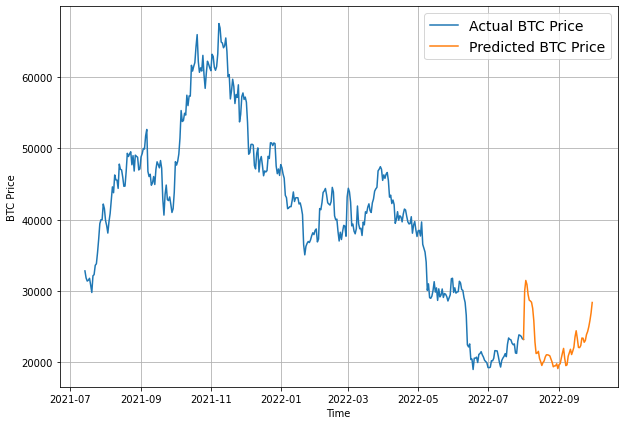

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plot_time_series(btc_price.index, btc_price["Price"], start=3300, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps_updated, future_forecast_updated, format="-", label="Predicted BTC Price")